In [132]:
# Setup dependencies (as taken from assignment 6)
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from joblib import load
import graycode

from pytorch_forecasting.metrics import QuantileLoss

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load data

In [133]:
df = pd.read_csv('day_ahead.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
df

,Day-ahead Price [EUR/MWh],time,tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure
datetime,,,,,,,,
2015-01-05 00:00:00,-0.243620,2400,-1.722376,-0.422598,0.563889,0.000000,0.96,2.163731
2015-01-05 01:00:00,-0.316395,100,-1.722376,-0.297098,0.572222,0.000000,0.96,2.058525
2015-01-05 02:00:00,-0.439933,200,-1.722376,-0.171598,0.580556,0.000000,0.96,2.058525
2015-01-05 03:00:00,-0.625914,300,-1.722376,-0.046098,0.588889,0.000000,0.96,1.953318
2015-01-05 04:00:00,-0.626363,400,-1.722376,-0.171598,0.575000,0.000000,0.96,1.953318
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.877205,1900,-1.130468,-0.673599,0.602778,0.054545,0.94,-1.728907
2020-12-31 20:00:00,0.665169,2000,-1.130468,-0.422598,0.625000,0.036364,0.93,-1.728907
2020-12-31 21:00:00,0.469755,2100,-1.130468,-0.171598,0.650000,0.054545,0.93,-1.623701


In [134]:
# pd.set_option('display.max_rows', 5)
# df["week"]=pd.Int64Index(df.index.isocalendar().week)
# df["month"]=df.index.month
# df["dayofweek"]=df.index.dayofweek

# print(df["dayofweek"].unique())
# print(df["month"].unique())
# print(df["week"].unique())





In [135]:
dayahead_scaler = load('dayahead_scaler.bin')
print(df)

                     Day-ahead Price [EUR/MWh]  time     tempC  windspeedKmph  \
datetime                                                                        
2015-01-05 00:00:00                  -0.243620  2400 -1.722376      -0.422598   
2015-01-05 01:00:00                  -0.316395   100 -1.722376      -0.297098   
2015-01-05 02:00:00                  -0.439933   200 -1.722376      -0.171598   
2015-01-05 03:00:00                  -0.625914   300 -1.722376      -0.046098   
2015-01-05 04:00:00                  -0.626363   400 -1.722376      -0.171598   
...                                        ...   ...       ...            ...   
2020-12-31 19:00:00                   0.877205  1900 -1.130468      -0.673599   
2020-12-31 20:00:00                   0.665169  2000 -1.130468      -0.422598   
2020-12-31 21:00:00                   0.469755  2100 -1.130468      -0.171598   
2020-12-31 22:00:00                   0.443699  2200 -1.278445      -0.422598   
2020-12-31 23:00:00         

# Time variable

In [136]:
time = (df['time'].values/100).astype(int)

In [137]:
# incremental representation of time
time_increment = time/10

In [138]:
# gray code binary
time_gray_code = np.empty([len(time), 5])
for i in range(len(time)):
    gray_code_str = '{:05b}'.format(graycode.tc_to_gray_code(time[i]))
    time_gray_code[i] = np.array(list(gray_code_str)).astype(np.int8)

In [139]:
# mutually exclusive binary representation
time_exclusive = np.zeros([len(time), 24])
for i in range(len(time)):
    time_exclusive[i][time[i] - 1] = 1
time_exclusive = time_exclusive[:,::-1] # reverse array to correspond to binary representation

# Dataset with time variables

In [140]:
time_exclusive

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [141]:
# no time variable
df0 = df.drop(columns=['time'])

In [142]:
# make copies of original dataset
df1 = df0.copy()
df2 = df0.copy()
df3 = df0.copy()

In [143]:
# incremental time representation
df1['time_increment'] = time_increment
df1['dow_sin'] = np.sin(df1.index.dayofweek*(2.*np.pi/7))
df1['dow_cos'] = np.cos(df1.index.dayofweek*(2.*np.pi/7))

df1['mnth_sin'] = np.sin((df1.index.month-1)*(2.*np.pi/12))
df1['mnth_cos'] = np.cos((df1.index.month-1)*(2.*np.pi/12))

df1['week_sin'] = np.sin((pd.Int64Index(df1.index.isocalendar().week)-1)*(2.*np.pi/53))
df1['week_cos'] = np.cos((pd.Int64Index(df1.index.isocalendar().week)-1)*(2.*np.pi/53))

# df1['hour_sine'] = np.sin((df1.index.hour)*(2.*np.pi/24))
# df1['hour_cos'] = np.cos((df1.index.hour)*(2.*np.pi/24))

display(df1)





,Day-ahead Price [EUR/MWh],tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure,time_increment,dow_sin,dow_cos,mnth_sin,mnth_cos,week_sin,week_cos
datetime,,,,,,,,,,,,,,
2015-01-05 00:00:00,-0.243620,-1.722376,-0.422598,0.563889,0.000000,0.96,2.163731,2.4,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 01:00:00,-0.316395,-1.722376,-0.297098,0.572222,0.000000,0.96,2.058525,0.1,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 02:00:00,-0.439933,-1.722376,-0.171598,0.580556,0.000000,0.96,2.058525,0.2,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 03:00:00,-0.625914,-1.722376,-0.046098,0.588889,0.000000,0.96,1.953318,0.3,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
2015-01-05 04:00:00,-0.626363,-1.722376,-0.171598,0.575000,0.000000,0.96,1.953318,0.4,0.000000,1.000000,0.0,1.000000,0.118273,0.992981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.877205,-1.130468,-0.673599,0.602778,0.054545,0.94,-1.728907,1.9,0.433884,-0.900969,-0.5,0.866025,-0.118273,0.992981
2020-12-31 20:00:00,0.665169,-1.130468,-0.422598,0.625000,0.036364,0.93,-1.728907,2.0,0.433884,-0.900969,-0.5,0.866025,-0.118273,0.992981
2020-12-31 21:00:00,0.469755,-1.130468,-0.171598,0.650000,0.054545,0.93,-1.623701,2.1,0.433884,-0.900969,-0.5,0.866025,-0.118273,0.992981


In [102]:
# gray code time representation
time_gray_code.shape
for i in range(time_gray_code.shape[1]):
    df2['gc_'+str(i)] = time_gray_code[:,i]

In [103]:
# mutually exclusive time representation
for i in range(time_exclusive.shape[1]):
    df3['ex_'+str(i)] = time_exclusive[:,i]

# Create Torch dataset

In [144]:
def create_torch_dataset(df, seq_length):
    
    delta = pd.Timedelta(seq_length, unit ='h')
    # define 1 hour object for convenience when using datetime as index in the dataframe to not include the last item
    hours_12 = pd.Timedelta(12, unit ='h') # used mostly for empty 12 hours 
    hour = pd.Timedelta(1, unit ='h')
    day = pd.Timedelta(1, unit ='d')
    
    ### creating training dataset
    train_y_start = dt.datetime(2015, 1, 5, 0, 0) + (delta+hours_12).ceil('1d')
    train_end = dt.datetime(2020, 10, 31, 23, 0)

    train_x = []
    train_y = []
    while train_y_start + day - hour <= train_end:
        train_x_start = train_y_start - delta - hours_12


        #print(train_x_start, train_y_start)
        train_x.append(df[train_x_start:train_x_start+delta - hour].values)
        train_y.append(df[train_y_start:train_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        train_y_start += day

    train_x = np.asarray(train_x)
    train_y = np.asarray(train_y)
    
    
    ### creating validation dataset
    val_y_start = dt.datetime(2020, 11, 1, 0, 0)
    val_end = dt.datetime(2020, 11, 30, 23, 0)

    val_x = []
    val_y = []
    while val_y_start + day - hour <= val_end:
        val_x_start = val_y_start - delta - hours_12

        val_x.append(df[val_x_start:val_x_start+delta - hour].values)
        val_y.append(df[val_y_start:val_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        val_y_start += day

    val_x = np.asarray(val_x)
    val_y = np.asarray(val_y)
    
    ### creating testing dataset
    test_y_start = dt.datetime(2020, 12, 1, 0, 0)
    test_end = dt.datetime(2020, 12, 31, 23, 0)

    test_x = []
    test_y = []
    while test_y_start + day - hour <= test_end:
        test_x_start = test_y_start - delta - hours_12

        test_x.append(df[test_x_start:test_x_start+delta - hour].values)
        test_y.append(df[test_y_start:test_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)

        test_y_start += day

    test_x = np.asarray(test_x)
    test_y = np.asarray(test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Define BLSTM model

In [145]:
class BLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, quantiles):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim*2, output_dim) # multiply hidden_dim by 2 because bidirectional
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        self.out_shape = len(quantiles)
        
        final_layers = [
            nn.Linear(hidden_dim*2, output_dim) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def add_noise_to_weights(self):
        with torch.no_grad():
            # add noise to lstm weights
            for weights in model.lstm._all_weights:
                for weight in weights:
                    noise = torch.normal(0, 0.01, size=self.lstm._parameters[weight].size())
                    self.lstm._parameters[weight].add_(noise)
            # add noise to linear layer weights, most likely unnecessary
#             for layer in self.final_layers:
#                 if hasattr(layer, 'weight'):
#                     noise = torch.normal(0, 0.05, size=layer.weight.size())
#                     layer.weight.add_(noise)

        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() #hidden layer output
        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() 
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
#         _out = self.fc(out[:, -1, :])
        
        return torch.stack([layer(out[:, -1, :]) for layer in self.final_layers], dim=1)

# (Hyper)parameters

In [190]:
# hyperparameters to set
seq_lengths = [12, 24, 36, 48, 72]
dfs = [ df1]
hidden_dim_ = [4, 8, 16, 32, 64, 128] # no. of dimension in hidden layer
num_layers_ = [1, 2, 3, 4] # no of hidden layers 


# predetermined parameters
output_dim = 24 
num_epochs = 500
batch_size = 64
quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
patience = 10 # for early stopping

## Training loop

In [191]:
# save average validation loss of 10 (patience value) epochs since the best performance, which are the last 10
validation_performance = np.zeros((len(dfs), len(seq_lengths), len(hidden_dim_), len(num_layers_)))

for df_type, df in enumerate(dfs):
    for seq_idx, seq in enumerate(seq_lengths):
        
        train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
                
        # create tensor objects
        x_train = torch.from_numpy(train_x).float()
        y_train = torch.from_numpy(train_y).float()
        x_val = torch.from_numpy(val_x).float()
        y_val = torch.from_numpy(val_y).float()
        x_test = torch.from_numpy(test_x).float()
        y_test = torch.from_numpy(test_y).float()

        # create training batch
        train_data = []
        for i in range(len(x_train)):
            train_data.append([x_train[i], y_train[i]])

        trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

        # other parameters for initializing the model
        num_train = x_train.shape[0]
        input_dim = x_train.shape[2]
        
        
        for hidden_idx, hidden_dim in enumerate(hidden_dim_):
            for layer_idx, num_layers in enumerate(num_layers_):
                print()
                print()
                print("starting time var type: ", df_type, " sequence length: ", 
                      seq, " num layers: ", num_layers, " hidden dim: ", hidden_dim)

                criterion = QuantileLoss(quantiles)
                model = BLSTM(input_dim=input_dim, 
                              hidden_dim=hidden_dim, 
                              output_dim=output_dim, 
                              num_layers=num_layers, 
                              quantiles=quantiles)
                #print(model)
                optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

                # Initialize early stopping variables
                val_loss_best = np.Inf
                patience_cnt = 0
                
                
                
            
                val_losses = []
                for t in range(num_epochs): 
                    
                    err = []
                    
                    # training
                    for batch in trainloader:
                        inputs, outputs = batch
                        model.add_noise_to_weights() # adding noise to lstm weights during the training
                        y_train_pred = model(inputs)

                        loss = torch.mean(torch.sum(criterion.loss(torch.transpose(y_train_pred,1,2), outputs), dim=2))
                        optimiser.zero_grad()
                        loss.backward()
                        optimiser.step()
                        err.append(loss.item())

                    # validation
                    with torch.no_grad():
                        preds=model(x_val)
                        val_loss = torch.mean(torch.sum(criterion.loss(torch.transpose(preds,1,2), y_val), dim=2)).item()
                        val_losses.append(val_loss)


                    if val_loss < val_loss_best:
                        val_loss_best = val_loss
                        patience_cnt = 0
                    else:
                        patience_cnt +=1
                        if patience_cnt == patience:
                            print("Early stopping: Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
                            break
                    
                    if (t+1) % 10 == 0:
                        print("Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
                    
                validation_performance[df_type, seq_idx, hidden_idx, layer_idx] = sum(val_losses[-patience:])/patience

print()
print()
print("Done!")



starting time var type:  0  sequence length:  12  num layers:  1  hidden dim:  4
Epoch  10 training loss:  0.8996216873912251 validation loss:  0.7250500917434692
Epoch  20 training loss:  0.8126557898872039 validation loss:  0.6882359385490417
Epoch  30 training loss:  0.7868907574345084 validation loss:  0.6646124124526978
Epoch  40 training loss:  0.7834436139639687 validation loss:  0.6761429905891418
Epoch  50 training loss:  0.7731407495105967 validation loss:  0.674623429775238
Early stopping: Epoch  52 training loss:  0.7665214187958661 validation loss:  0.67425137758255


starting time var type:  0  sequence length:  12  num layers:  2  hidden dim:  4
Epoch  10 training loss:  0.9274047507959253 validation loss:  0.8177934288978577
Epoch  20 training loss:  0.821309383301174 validation loss:  0.7270992994308472
Epoch  30 training loss:  0.7728941186385996 validation loss:  0.6697368621826172
Epoch  40 training loss:  0.7510447300532285 validation loss:  0.6532520055770874
Ep

Epoch  20 training loss:  0.6903967497979894 validation loss:  0.653596818447113
Early stopping: Epoch  26 training loss:  0.6614972572116291 validation loss:  0.691685676574707


starting time var type:  0  sequence length:  12  num layers:  3  hidden dim:  64
Epoch  10 training loss:  0.9127686707412496 validation loss:  0.798248291015625
Epoch  20 training loss:  0.7676949203014374 validation loss:  0.6585322022438049
Epoch  30 training loss:  0.667191859553842 validation loss:  0.6743280291557312
Epoch  40 training loss:  0.6280245009590598 validation loss:  0.7550547122955322
Early stopping: Epoch  43 training loss:  0.5739971539553474 validation loss:  0.8905426859855652


starting time var type:  0  sequence length:  12  num layers:  4  hidden dim:  64
Epoch  10 training loss:  0.984607978778727 validation loss:  0.8153757452964783
Epoch  20 training loss:  0.8038510557483224 validation loss:  0.7907624840736389
Epoch  30 training loss:  0.6956192544277977 validation loss:  0.74

Early stopping: Epoch  24 training loss:  0.8258268885752734 validation loss:  0.7762820720672607


starting time var type:  0  sequence length:  24  num layers:  1  hidden dim:  32
Epoch  10 training loss:  0.7879777576993493 validation loss:  0.6468907594680786
Epoch  20 training loss:  0.7274990432402667 validation loss:  0.6347853541374207
Epoch  30 training loss:  0.6766413459006477 validation loss:  0.6397956609725952
Epoch  40 training loss:  0.657440218855353 validation loss:  0.6372900009155273


KeyboardInterrupt: 

## get best hyperparameter

In [192]:
performance = validation_performance

In [193]:
#print(performance)

In [194]:
# get the hyperparameter setting of model with lowest validation loss
best = np.amin(performance)
result = np.where(performance == best)

In [195]:
print(best)
print(result)

0.0
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]), array([3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 1, 1,
       1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
   

# Train model with adjusted hyperparameters

In [226]:
# New hyperparameters

seq = 12
df = df1
hidden_dim = 16 # no. of dimension in hidden layer
num_layers = 2 # no of hidden layers 


# predetermined parameters
output_dim = 24 
num_epochs = 500
batch_size = 64
quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
patience = 20 # for early stopping

In [227]:
train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
print(train_x.shape)

(2126, 12, 14)


In [228]:
train_x, train_y, val_x, val_y, test_x, test_y = create_torch_dataset(df, seq)
                
# create tensor objects
x_train = torch.from_numpy(train_x).float()
y_train = torch.from_numpy(train_y).float()
x_val = torch.from_numpy(val_x).float()
y_val = torch.from_numpy(val_y).float()
x_test = torch.from_numpy(test_x).float()
y_test = torch.from_numpy(test_y).float()

# create training batch
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

# other parameters for initializing the model
num_train = x_train.shape[0]
input_dim = x_train.shape[2]

print("starting sequence length: ", 
      seq, " num layers: ", num_layers, " hidden dim: ", hidden_dim)

criterion = QuantileLoss(quantiles)
model = BLSTM(input_dim=input_dim, 
              hidden_dim=hidden_dim, 
              output_dim=output_dim, 
              num_layers=num_layers, 
              quantiles=quantiles)
#print(model)
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Initialize early stopping variables
val_loss_best = np.Inf
patience_cnt = 0




val_losses = []
for t in range(num_epochs): 

    err = []

    # training
    for batch in trainloader:
        inputs, outputs = batch
        model.add_noise_to_weights() # adding noise to lstm weights during the training
        y_train_pred = model(inputs)

        loss = torch.mean(torch.sum(criterion.loss(torch.transpose(y_train_pred,1,2), outputs), dim=2))
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        err.append(loss.item())

    # validation
    with torch.no_grad():
        preds=model(x_val)
        val_loss = torch.mean(torch.sum(criterion.loss(torch.transpose(preds,1,2), y_val), dim=2)).item()
        val_losses.append(val_loss)


    if val_loss < val_loss_best:
        val_loss_best = val_loss
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            print("Early stopping: Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)
            break

    if (t+1) % 2 == 0:
        print("Epoch ", t+1, "training loss: ", sum(err)/len(err), "validation loss: ", val_loss)


starting sequence length:  12  num layers:  2  hidden dim:  16
Epoch  2 training loss:  1.4281991404645584 validation loss:  1.0309573411941528
Epoch  4 training loss:  1.1663956484373879 validation loss:  0.7989909052848816
Epoch  6 training loss:  0.9606833878685447 validation loss:  0.7512006163597107
Epoch  8 training loss:  0.8730781393892625 validation loss:  0.7471321821212769
Epoch  10 training loss:  0.8145209542092156 validation loss:  0.7494800090789795
Epoch  12 training loss:  0.7915438089300605 validation loss:  0.707205593585968
Epoch  14 training loss:  0.7679938183111303 validation loss:  0.6707928776741028
Epoch  16 training loss:  0.7628652576137992 validation loss:  0.6710180640220642
Epoch  18 training loss:  0.7407765958239051 validation loss:  0.6750727891921997
Epoch  20 training loss:  0.7282000333070755 validation loss:  0.624915361404419
Epoch  22 training loss:  0.7149090731845182 validation loss:  0.6549781560897827
Epoch  24 training loss:  0.7150050708476

In [229]:
#val_losses

# Test performance and plot

In [230]:
# Make the prediction on the meshed x-axis
model.eval()
with torch.no_grad():
    preds=model(x_test)

In [231]:
preds = dayahead_scaler.inverse_transform(preds)

In [232]:
test_df = df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 31, 23, 0)][['Day-ahead Price [EUR/MWh]']]
test_df[test_df.columns] = dayahead_scaler.inverse_transform(test_df.values)
for i in range(preds.shape[1]):
    y=preds[:,i,:]
    test_df[str(i)]=y.flatten()

In [233]:
preds_test = torch.from_numpy(np.transpose(preds,(0,2,1)))
y_test_price = torch.from_numpy(test_df['Day-ahead Price [EUR/MWh]'].values.reshape((-1, 24)))

# quantile loss in term of dayahead price (not normalize or standardize)
torch.mean(torch.sum(criterion.loss(preds_test, y_test_price), dim=2)).item()

28.906176612019458

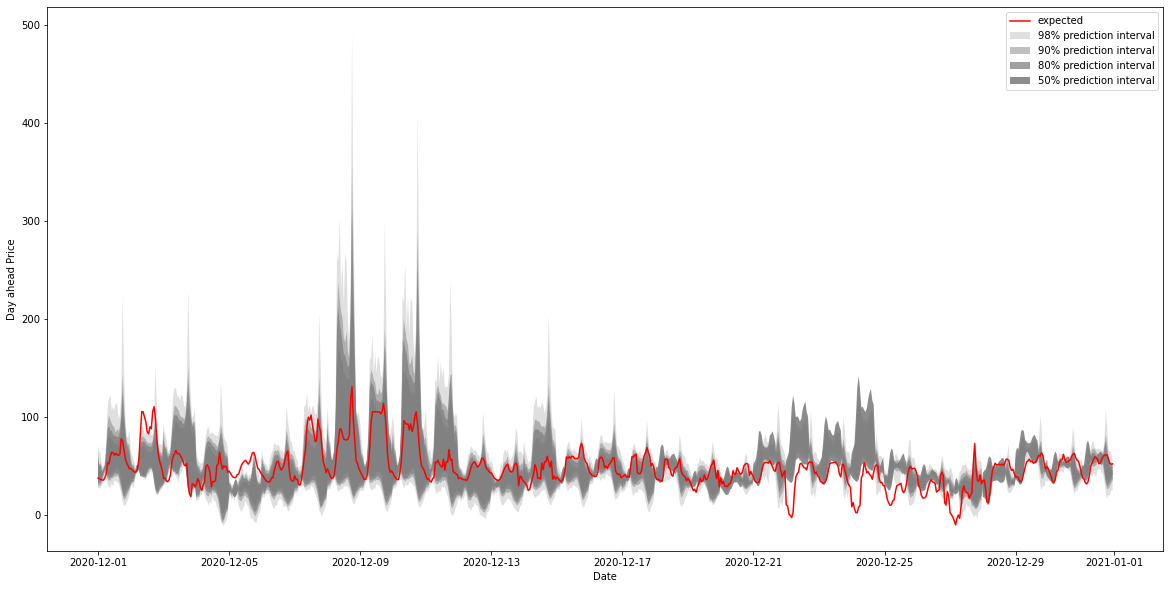

In [234]:
# plot whole data

fig = plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='expected')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['8'].values.flatten(), test_df['0'].values.flatten()]),
         alpha=.25, fc='grey', ec='None', label='98% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['7'].values.flatten(), test_df['1'].values.flatten()]),
         alpha=.5, fc='grey', ec='None', label='90% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['6'].values.flatten(), test_df['2'].values.flatten()]),
         alpha=.75, fc='grey', ec='None', label='80% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['5'].values.flatten(), test_df['3'].values.flatten()]),
         alpha=0.9, fc='grey', ec='None', label='50% prediction interval')

plt.xlabel('Date')
plt.ylabel('Day ahead Price')
plt.legend(loc='upper right')
plt.show()

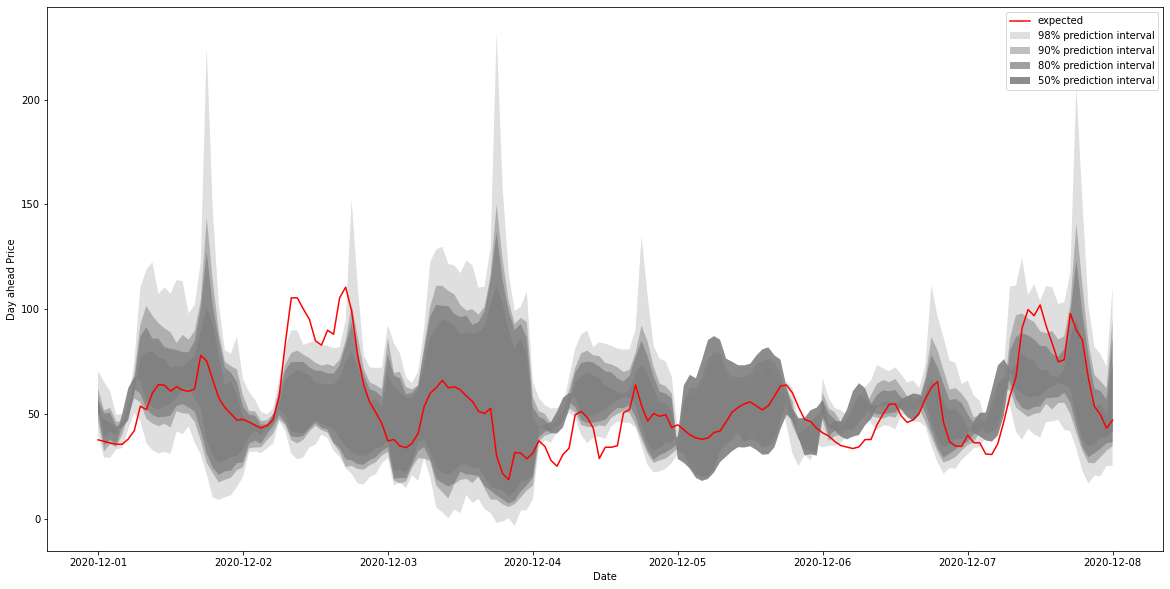

In [235]:
# plot first 7 days

part_df = test_df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 8, 0, 0)]
part_df

fig = plt.figure(figsize=(20,10))
plt.plot(part_df.index, part_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='expected')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['8'].values.flatten(), part_df['0'].values.flatten()]),
         alpha=.25, fc='grey', ec='None', label='98% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['7'].values.flatten(), part_df['1'].values.flatten()]),
         alpha=.5, fc='grey', ec='None', label='90% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['6'].values.flatten(), part_df['2'].values.flatten()]),
         alpha=.75, fc='grey', ec='None', label='80% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['5'].values.flatten(), part_df['3'].values.flatten()]),
         alpha=0.9, fc='grey', ec='None', label='50% prediction interval')

plt.xlabel('Date')
plt.ylabel('Day ahead Price')
plt.legend(loc='upper right')
plt.show()